# $\textrm{Introdution and Background}$

# $\textrm{Data Description}$

We ran into a couple problems looking for the income data, since we did not find a consistent stream of data for all of our cities. We eventually found the FactsFinder webpage that contains all the Census data from the United States (https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml). 

We were able to successfully find the income of a couple of cities from 2010-2016, and decided to scrape the income data from this website. Another roadblock we ran into was the fact that the website utilizes JavaScript, and the data we wanted to scrape was not readily available to us inside the HTML source code. Instead of using an API such as Mechanize or BeautifulSoup, we had to use Selenium Webdriver, a tool that esentially opens a "hidden" browser that can access the "generated" JavaScript HTML code that is not displayed the moment we access a page.

Yet another critical error kept happening, the fact that Selenium was way too fast and tried to scrape the text that was still loading, resulting in many errors. The only way we managed to fix this was to use Python's time package and make the code stop for 5 seconds before trying to scrape the next set of data from a new page. Lesser values worked sometimes, but we were relying on the internet connection speed, which varied over time. Waiting five seconds made it possible to scrape any kind of data we wanted without running into errors. Doing so made the scraping code take more than an hour, however. We saved the resultant dataframes and converted into CSV files for easy data analysis. 

The next cell contains the scraping code for the median income, unemployment rate, and mean commute time. It is not recommended to run it, because it takes a long time for it to work. 

In [ ]:
# Importing packages we need
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options 
import selenium.webdriver.support.ui as ui
import time

# Make Selenium invisible for running
chrome_options = Options()  
chrome_options.add_argument("--headless")
br = webdriver.Chrome(chrome_options=chrome_options, executable_path=r'./chromedriver.exe')

In [11]:
# Warning: code takes more than an hour to run since we have to wait until every
# page's Javascript content loads. That takes around 1-2 seconds normally, but
# sometimes may take one second longer than that, causing the program to crash.
# We use 5 seconds just in case, to avoid any possible hangups in the process.

# Scrapes median income, unemployment rate, and mean commute times of every city
def scraping_cities(city, row):
  
    br.get("https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml")
    wait = ui.WebDriverWait(br,15)
    time.sleep(2)
    # Types search terms for a city
    element = wait.until(lambda br:br.find_element_by_id('cfsearchtextbox'))
    element.clear()
    element.send_keys(city)

    # Submits form
    element =  wait.until(lambda br: br.find_element_by_xpath('//*[@id="communityfactssubmit"]'))
    element.click()

    # Clicking the income tab
    time.sleep(2.5)
    element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="leftnav"]/a[7]'))
    element.click()

    # Getting table link
    time.sleep(2.5)
    element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="cf-content"]/div[2]/div[1]/ul[1]/li[1]/div/a'))
    href = element.get_attribute('href')
    br.get(href)

    # Loop to scrape data from 2016 to 2010
    for i in range(2, 9):
        time.sleep(5)
            
        # Append unemployment rate
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="data"]/tbody/tr[11]/td[3]'))
        unemploymentDF.iloc[row, i-2] = element.text
        
        # Append commute time rate
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="data"]/tbody/tr[33]/td[1]'))
        commuteDF.iloc[row, i-2] = element.text
        
        # Append median income data
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="data"]/tbody/tr[79]/td[1]'))
        incomeDF.iloc[row, i-2] = element.text
        
        # Stop from getting nonexistent element
        if i == 8:
            break
        
        # Get previous year
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="year_selector_content"]/ul/li['+ str(i) +']/a'))
        element.click()


In the next cell, we get the list of cities that we are working with, and create the Pandas data frame objects to store all the information we need. We run while loops with the parser function to append elements to a new row, and modify column (year) values per dataframe. 

There are three resultant CSV files:
--cities_median_income.csv
--cities_unemployment_rate.csv
--cities_mean_commute_time.csv

# $\textrm{Data Cleaning/Preprocessing}$

In [1]:
import pandas as pd
import numpy as np
import scipy.interpolate as sp_interpolate

In [2]:
# our original wishlist of cities
cities = [
    "Birmingham, AL",
    "Montgomery, AL",
    "Anchorage, AK",
    "Juneau, AK",
    "Phoenix, AZ",
    "Tucson, AZ",
    "Little Rock, AR",
    "Fort Smith, AR",
    "San Diego, CA",
    "Los Angeles, CA",
    "Sacramento, CA",
    "Denver, CO",
    "Colorado Springs, CO",
    "Aurora, CO",
    "Bridgeport, CT",
    "Hartford, CT",
    "Dover, DE",
    "Wilmington, DE",
    "Jacksonville, FL",
    "Miami, FL",
    "Tallahassee, FL",
    "Atlanta, GA",
    "Savannah, GA",
    "Honolulu, HI",
    "Kauai, HI",
    "Maui, HI",
    "Boise, ID",
    "Meridian, ID",
    "Chicago, IL",
    "Springfield, IL",
    "Fort Wayne, IN",
    "Indianapolis, IN",
    "Cedar Rapids, IA",
    "Des Moines, IA",
    "Topeka, KS",
    "Wichita, KS",
    "Frankfort, KY",
    "Louisville, KY",
    "Baton Rouge, LA",
    "New Orleans, LA",
    "Augusta, ME",
    "Portland, ME",
    "Baltimore, MD",
    "Annapolis, MD",
    "Boston, MA",
    "Worcester, MA",
    "Detroit, MA",
    "Lansing, MA",
    "Minneapolis, MN",
    "Saint Paul, MN",
    "Jackson, MS",
    "Gulfport, MS",
    "Kansas City, MO",
    "Jefferson City, MO",
    "Billings, MT",
    "Helena, MT",
    "Lincoln, NE",
    "Omaha, NE",
    "Carson City, NV",
    "Las Vegas, NV",
    "Reno, NV",
    "Concord, NH",
    "Manchester, NH",
    "Newark, NJ",
    "Trenton, NJ",
    "Albuquerque, NM",
    "Santa Fe, NM",
    "Albany, NY",
    "New York City, NY",
    "Charlotte, NC",
    "Raleigh, NC",
    "Bismarck, ND",
    "Fargo, ND",
    "Columbus, OH",
    "Cleveland, OH",
    "Oklahoma City, OK",
    "Tulsa, OK",
    "Portland, OR",
    "Salem, OR",
    "Harrisburg, PA",
    "Philadelphia, PA",
    "Providence, RI",
    "Warwick, RI",
    "Charleston, SC",
    "Columbia, SC",
    "Pierre, SD",
    "Sioux Falls, SD",
    "Nashville, TN",
    "Memphis, TN",
    "Austin, TX",
    "El Paso, TX",
    "Houston, TX",
    "Salt Lake City, UT",
    "West Valley City, UT",
    "Burlington, VT",
    "Montpelier, VT",
    "Richmond, VA",
    "Virginia Beach, VA",
    "Olympia, WA",
    "Seattle, WA",
    "Charleston, WV",
    "Huntington, WV",
    "Madison, WI",
    "Milwaukee, WI",
    "Casper, WY",
    "Cheyenne, WY"
]

## Income

There is a general belief that the wealthier people are the happier they are. There is research on the matter correlating happiness to a sudden money increase (http://time.com/4856954/can-money-buy-you-happiness/), but over time, people will compare themselves to other rich people and they want more and more and the search of happiness never stops... Or does it?

Whether or not money makes people happier, it is a definitely an important part in people's lives. With money, people are able to buy houses, commodities, and luxuries. We are interested to know what city is the happiest depending on many factors, and income should be one of the most important of them. 

In order for our happiness model to be able to predict future values, we need to look at income in a longitudinal manner. In other words, we need data from the recent past to start building our model.

In [9]:
income = pd.read_csv('Income_Data/cities_median_income.csv')
income.head()

,City,Median Income 2016,Median Income 2015,Median Income 2014,Median Income 2013,Median Income 2012,Median Income 2011,Median Income 2010
0,"Birmingham, AL","46,346","44,463","44,447","44,716","44,710","45,423","45,198"
1,"Montgomery, AL","63,847","62,201","62,568","62,418","61,896","62,645","61,229"
2,"Anchorage, AK","102,500","99,630","98,317","96,935","95,632","94,073","91,251"
3,"Juneau, AK","104,005","102,355","97,588","96,025","95,433","93,994","89,373"
4,"Phoenix, AZ","69,216","66,345","65,770","65,199","65,968","66,709","66,996"


In [4]:
# rename columns
income.columns = ['city', '2016', '2015', '2014', '2013', '2012', '2011', '2010']

In [5]:
# capitalize "city" in "Salt Lake City"
income.loc[income['city'] == "Salt Lake city, UT", 'city'] = "Salt Lake City, UT"

In [6]:
# unpivot
income = pd.melt(income, id_vars=['city'], var_name='year', value_name='median income') \
           .sort_values(['city', 'year']) \
           .reset_index(drop=True)

In [7]:
# convert strings to numbers
income['median income'] = income['median income'].map(lambda value: int(value.replace(',', '')))

In [8]:
# convert to MultiIndex
income.set_index(['city', 'year'], inplace=True)

In [9]:
income.head()

median income
city       year               
Albany, NY 2010          73470
           2011          75821
           2012          76707
           2013          77687
           2014          78285

## Unemployment

In [20]:
unemployment = pd.read_csv('Income_Data/cities_unemployment_rate.csv')

In [21]:
unemployment = pd.read_csv('Income_Data/cities_unemployment_rate.csv')
unemployment.head()

,City,Unemployment Rate 2016,Unemployment Rate 2015,Unemployment Rate 2014,Unemployment Rate 2013,Unemployment Rate 2012,Unemployment Rate 2011,Unemployment Rate 2010
0,"Birmingham, AL",11.8%,13.3%,14.5%,15.3%,14.5%,13.6%,12.9%
1,"Montgomery, AL",8.4%,8.8%,8.9%,8.9%,8.7%,8.6%,7.9%
2,"Anchorage, AK",6.0%,6.7%,6.9%,7.3%,7.3%,7.2%,7.4%
3,"Juneau, AK",4.9%,5.2%,5.6%,5.3%,5.1%,5.3%,5.8%
4,"Phoenix, AZ",7.7%,8.8%,9.9%,10.6%,9.7%,8.7%,7.4%


In [11]:
# rename columns
unemployment.columns = ['city', '2016', '2015', '2014', '2013', '2012', '2011', '2010']

In [12]:
# capitalize "city" in "Salt Lake City"
unemployment.loc[unemployment['city'] == "Salt Lake city, UT", 'city'] = "Salt Lake City, UT"

In [13]:
# unpivot
unemployment = pd.melt(unemployment, id_vars=['city'], var_name='year', value_name='unemployment rate') \
                 .sort_values(['city', 'year']) \
                 .reset_index(drop=True)

In [14]:
# convert percentages to decimals
unemployment['unemployment rate'] = unemployment['unemployment rate'] \
                                    .map(lambda rate: float(rate.rstrip('%'))/100)

In [15]:
# convert to MultiIndex
unemployment.set_index(['city', 'year'], inplace=True)

In [16]:
unemployment.head()

unemployment rate
city       year                   
Albany, NY 2010              0.060
           2011              0.065
           2012              0.070
           2013              0.073
           2014              0.068

## Traffic

In [27]:
traffic = pd.read_csv('Income_Data/cities_mean_commute_time.csv')

In [28]:
traffic = pd.read_csv('Income_Data/cities_mean_commute_time.csv')
traffic.head()

,City,Mean Commute Time 2016,Mean Commute Time 2015,Mean Commute Time 2014,Mean Commute Time 2013,Mean Commute Time 2012,Mean Commute Time 2011,Mean Commute Time 2010
0,"Birmingham, AL",21.4,21.4,21.6,21.7,21.8,21.7,22.0
1,"Montgomery, AL",20.0,19.3,19.5,19.3,19.5,19.5,19.7
2,"Anchorage, AK",19.1,19.5,19.4,19.4,19.0,18.6,18.2
3,"Juneau, AK",15.6,15.1,14.8,15.1,15.5,15.2,15.3
4,"Phoenix, AZ",25.1,24.8,24.5,24.4,24.4,24.7,24.8


In [18]:
# rename columns
traffic.columns = ['city', '2016', '2015', '2014', '2013', '2012', '2011', '2010']

In [19]:
# capitalize "city" in "Salt Lake City"
traffic.loc[traffic['city'] == "Salt Lake city, UT", 'city'] = "Salt Lake City, UT"

In [20]:
# unpivot
traffic = pd.melt(traffic, id_vars=['city'], var_name='year', value_name='mean commute time') \
           .sort_values(['city', 'year']) \
           .reset_index(drop=True)

In [21]:
# convert to MultiIndex
traffic.set_index(['city', 'year'], inplace=True)

In [22]:
traffic.head()

mean commute time
city       year                   
Albany, NY 2010               19.7
           2011               19.9
           2012               20.0
           2013               20.0
           2014               20.1

## Crime

In [23]:
crime = pd.read_pickle('crime_data/crime_data.pkl')
crime.head()

arson assault burglary murder rape robbery  theft  \
city           year                                                     
Birmingham, AL 2002   211    1697     4389     65  239    1186  11640   
               2003   175    1706     4831     85  204    1352  11934   
               2004   142    1593     5156     59  240    1369  11970   
               2005   136    1675     4933    104  241    1429  11962   
               2006   228    1422     4813    104  220    1429  12113   

                    vehicle theft population  
city           year                           
Birmingham, AL 2002          2049        NaN  
               2003          2809        NaN  
               2004          2351        NaN  
               2005          2028        NaN  
               2006          2081        NaN

In [24]:
# only keep 2009–2016
crime.drop([str(year) for year in range(2000, 2008+1)], level='year', inplace=True)

In [25]:
# the only population value we're missing (2009 onward) is Chicago 2013,
# so we'll fill it with the mean of Chicago's 2012 and 2014 populations
crime.loc['Chicago, IL', '2013'].loc['population'] \
    = crime.loc['Chicago, IL'].loc[['2012', '2014'], 'population'].mean()

In [26]:
# rescale crime values to occurence per capita
for col_name in crime.columns:
    crime[col_name] = crime[col_name]/crime['population']
crime.drop('population', axis=1, inplace=True)
# append "rate" to column names
crime.rename(columns=lambda col_name: col_name + " rate", inplace=True)

In [27]:
# These cities are missing all data points for these metrics,
# so we'll fill those with zeros
crime.loc['Boston, MA', 'arson rate'] = 0
crime.loc['New York City, NY', 'arson rate'] = 0
crime.loc['Huntington, WV', 'burglary rate'] = 0

In [28]:
# These cities are missing half or more data points for these metrics,
# so we'll fill them with the means of the available data points for those metrics for each city
crime.loc['Montgomery, AL', 'arson rate'] =   crime.loc['Montgomery, AL', 'arson rate']                   \
                                              .fillna(crime.loc['Montgomery, AL', 'arson rate'].mean())   \
                                              .values
crime.loc['Tucson, AZ', 'theft rate'] =       crime.loc['Tucson, AZ', 'theft rate']                       \
                                              .fillna(crime.loc['Tucson, AZ', 'theft rate'].mean())       \
                                              .values
crime.loc['New Orleans, LA', 'arson rate'] =  crime.loc['New Orleans, LA', 'arson rate']                  \
                                              .fillna(crime.loc['New Orleans, LA', 'arson rate'].mean())  \
                                              .values
crime.loc['Philadelphia, PA', 'arson rate'] = crime.loc['Philadelphia, PA', 'arson rate']                 \
                                              .fillna(crime.loc['Philadelphia, PA', 'arson rate'].mean()) \
                                              .values

In [29]:
# These cities are missing just a few data points,
# so we'll fill them by cubic interpolation
def interpolate_crime_data(series):
    x = series.dropna().index.values.astype(int) # year
    y = series.dropna().values # data
    
    f = sp_interpolate.interp1d(x, y, kind='cubic', fill_value='extrapolate')
    x_all = series.index.values.astype(int)
    return f(x_all)

missing_data = [
    ('Birmingham, AL', 'arson rate'),
    ('Phoenix, AZ', 'arson rate'),
    ('Chicago, IL', 'arson rate'),
    ('Chicago, IL', 'assault rate'),
    ('Chicago, IL', 'rape rate'),
    ('Indianapolis, IN', 'arson rate'),
    ('Topeka, KS', 'arson rate'),
    ('Louisville, KY', 'arson rate'),
    ('Lincoln, NE', 'arson rate'),
    ('Omaha, NE', 'arson rate'),
    ('Albuquerque, NM', 'arson rate'),
    ('Santa Fe, NM', 'arson rate'),
    ('Albany, NY', 'arson rate'),
    ('Columbus, OH', 'arson rate'),
    ('Providence, RI', 'vehicle theft rate'),
    ('West Valley City, UT', 'burglary rate'),
    ('Madison, WI', 'arson rate')
]

for city, injustice in missing_data:
    crime.loc[city, injustice] = interpolate_crime_data(crime.loc[city, injustice])

In [30]:
crime.head()

arson rate assault rate burglary rate  murder rate  \
city           year                                                        
Birmingham, AL 2009  0.000593738   0.00615289     0.0220739  0.000285874   
               2011  0.000576766   0.00898442     0.0272252  0.000253214   
               2012  0.000548611   0.00954207      0.022057  0.000314162   
               2013  0.000606034   0.00774525     0.0189527  0.000297168   
               2014  0.000683591   0.00982486     0.0176791   0.00024515   

                       rape rate robbery rate theft rate vehicle theft rate  
city           year                                                          
Birmingham, AL 2009  0.000870816   0.00505777    0.05078         0.00701051  
               2011  0.000853426   0.00474074  0.0493393         0.00709469  
               2012  0.000712725   0.00460927  0.0423978         0.00488592  
               2013  0.000839619   0.00457073  0.0408536         0.00697167  
               2014  0.000858025   0.00495486  0.0412182         0.00676991

## Happiness

In [31]:
happiness = pd.read_csv('Happy_Data/timeline_happy.csv')
happiness.head()

,Geography,2014,2015,2016
0,"Akron, OH",57.7,60.3,61.7
1,"Albany-Schenectady-Troy, NY",59.2,60.8,59.9
2,"Albuquerque, NM",60.3,57.0,59.4
3,"Allentown-Bethlehem-Easton, PA-NJ",61.2,60.4,61.2
4,"Anchorage, AK",65.7,NaN,64.4


In [32]:
# rename columns
happiness.columns = ['city', '2014', '2015', '2016']

In [33]:
# why is there an extra comma in this one??
happiness.loc[happiness['city'] == "Fayetteville, Springdale-Rogers, AR-MO", 'city'] \
    = "Fayetteville-Springdale-Rogers, AR-MO"

In [34]:
# filter out regions not on our wishlist, and rename regions to cities accordingly
def rename_regions(region):
    region_city_words, region_states = [area.replace('-', ' ').split() for area in region.split(", ")]
    for city_words, state in [(city.split(), state) for city, state in [city.split(", ") for city in cities]]:
        # reconstruct "City, STATE" becuase I like the way I wrote the for loop too much to restructure it
        city_name = "{city}, {state}".format(city=' '.join(city_words), state=state)
        # the Happiness data uses "St." instead of "Saint"
        city_words = ["St." if word == "Saint" else word for word in city_words]
        if all([city_word in region_city_words for city_word in city_words]):
            if state in region_states:
                return city_name
    return False
happiness['city'] = happiness['city'].map(rename_regions)
happiness = happiness.loc[happiness['city'] != False]

In [35]:
# unpivot
happiness = pd.melt(happiness, id_vars=['city'], var_name='year', value_name='happiness') \
           .sort_values(['city', 'year']) \
           .reset_index(drop=True)

In [36]:
# drop NaN rows because they are worthless to our cause
happiness.dropna(inplace=True)

In [37]:
# convert to MultiIndex
happiness.set_index(['city', 'year'], inplace=True)

In [38]:
happiness.head()

happiness
city            year           
Albany, NY      2014       59.2
                2015       60.8
                2016       59.9
Albuquerque, NM 2014       60.3
                2015       57.0

## Everything Together

In [39]:
data = income.merge(unemployment, left_index=True, right_index=True)          \
           .merge(traffic, left_index=True, right_index=True)               \
           .merge(crime, left_index=True, right_index=True)                 \
           .merge(happiness, how='left', left_index=True, right_index=True) \
           .astype(float)
data.head()

median income  unemployment rate  mean commute time  \
city       year                                                        
Albany, NY 2010        73470.0              0.060               19.7   
           2011        75821.0              0.065               19.9   
           2012        76707.0              0.070               20.0   
           2013        77687.0              0.073               20.0   
           2014        78285.0              0.068               20.1   

                 arson rate  assault rate  burglary rate  murder rate  \
city       year                                                         
Albany, NY 2010    0.000173      0.006698       0.009988     0.000022   
           2011    0.000122      0.005921       0.009105     0.000041   
           2012    0.000109      0.005153       0.009034     0.000041   
           2013    0.000126      0.005370       0.007197     0.000082   
           2014    0.000122      0.005102       0.006927     0.000081   

                 rape rate  robbery rate  theft rate  vehicle theft rate  \
city       year                                                            
Albany, NY 2010   0.000453      0.003408    0.037621            0.002470   
           2011   0.000336      0.003255    0.035749            0.002055   
           2012   0.000438      0.002536    0.033599            0.001568   
           2013   0.000306      0.002317    0.033107            0.001450   
           2014   0.000548      0.002404    0.031269            0.001237   

                 happiness  
city       year             
Albany, NY 2010        NaN  
           2011        NaN  
           2012        NaN  
           2013        NaN  
           2014       59.2

# $\textrm{Data Visualization}$

In [40]:
import matplotlib.pyplot as plt

# $\textrm{Data Analysis and Results}$

In [41]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression

## Calculate Multiple Correlation Coefficient

Only looking at the years for which we have happiness data.

Methodology from [Wikipedia](https://en.wikipedia.org/wiki/Multiple_correlation#Computation).

Let $R$ denote the coefficient of multiple correlation:  
"the Pearson correlation coefficient between the predicted and the actual values of the dependent variable in a linear regression model".

$
R=\sqrt{\mathbf{c}^TR_{xx}^{-1}\mathbf{c}},\\
\textrm{where}\\
\textrm{the vector }\mathbf{c}=(r_{x_1y},r_{x_2y},\ldots,r_{x_Ny})^T
        \textrm{ contains correlations }r_{x_ny}
        \textrm{ between the predictors }x_n
        \textrm{ and the target }y,\\
\textrm{the matrix }R_{xx}=\left(\begin{array}{c c c c}
r_{x_1x_1}&r_{x_1x_2}&\cdots&r_{x_1x_N}\\
r_{x_2x_1}&\ddots&&\vdots\\
\vdots&&\ddots&\\
r_{x_Nx_1}&\cdots&&r_{x_Nx_N}\\
\end{array}\right)\textrm{ is the correlation matrix between the predictors}.
$

In [42]:
c = data.dropna().corr().values[:-1,[-1]]
display(data.dropna().corr().drop('happiness', axis='index')['happiness'])

median income         0.133706
unemployment rate    -0.353547
mean commute time    -0.016936
arson rate           -0.237336
assault rate         -0.386573
burglary rate        -0.448112
murder rate          -0.477110
rape rate             0.066838
robbery rate         -0.519190
theft rate           -0.152628
vehicle theft rate   -0.231527
Name: happiness, dtype: float64

None of our variables individually are particularly strongly correlated with happiness.

In [43]:
R_xx = data.dropna().corr().values[:-1,:-1]
display(data.dropna().corr().drop('happiness', axis='index').drop('happiness', axis='columns'))

,median income,unemployment rate,mean commute time,arson rate,assault rate,burglary rate,murder rate,rape rate,robbery rate,theft rate,vehicle theft rate
median income,1.000000,-0.505509,0.167971,-0.278277,-0.185433,-0.375989,-0.293157,-0.225765,-0.311808,-0.082478,-0.110416
unemployment rate,-0.505509,1.000000,0.305801,0.173044,0.153827,0.215680,0.373287,-0.029590,0.464963,-0.173906,0.142741
mean commute time,0.167971,0.305801,1.000000,-0.153104,-0.211207,-0.305332,0.070645,-0.346578,0.091533,-0.434058,-0.110841
arson rate,-0.278277,0.173044,-0.153104,1.000000,0.273050,0.540993,0.373815,0.319267,0.425747,0.206279,0.336884
assault rate,-0.185433,0.153827,-0.211207,0.273050,1.000000,0.650798,0.537761,0.269691,0.649698,0.357756,0.451951
burglary rate,-0.375989,0.215680,-0.305332,0.540993,0.650798,1.000000,0.520745,0.359638,0.647872,0.513332,0.544436
murder rate,-0.293157,0.373287,0.070645,0.373815,0.537761,0.520745,1.000000,0.125618,0.795926,0.063153,0.410735
rape rate,-0.225765,-0.029590,-0.346578,0.319267,0.269691,0.359638,0.125618,1.000000,0.175994,0.399257,0.313619
robbery rate,-0.311808,0.464963,0.091533,0.425747,0.649698,0.647872,0.795926,0.175994,1.000000,0.152506,0.575022
theft rate,-0.082478,-0.173906,-0.434058,0.206279,0.357756,0.513332,0.063153,0.399257,0.152506,1.000000,0.391938


The strongest pairwise correlation between the metrics is murder and robbery ($r=0.795926$).  
The second-strongest is between burglary and assault ($r=0.650798$).

In [44]:
R = np.sqrt(c.T@np.linalg.inv(R_xx)@c)
print(R[0,0])

0.636790557834221


$R=0.636790557834221$

Our metrics do a better-than-chance job of predicting happiness!

## Fit a Regression Model to Available Happiness Data

In [45]:
# years for which we have happiness data
X_available = data.values[~np.isnan(data.values[:,-1])][:,:-1]
y_available = data.values[~np.isnan(data.values[:,-1])][:,[-1]]

In [46]:
model = sk_LinearRegression().fit(X_available, y_available)

This makes an assumption that years are independent

In [47]:
print("coefficients:\n{}".format(model.coef_[0]))
print("intercept:\n{}".format(model.intercept_[0]))

coefficients:
[-3.50471158e-05 -2.17731622e+01  4.12652456e-02 -8.04469628e+01
 -1.62513781e+01 -1.76423165e+02 -3.79872080e+03  1.69499512e+03
 -2.99652361e+02 -3.06937178e+01  1.22116685e+02]
intercept:
66.78267223412386


$
\begin{array}{l r l l}
    \textrm{happiness}_\textrm{predicted}=&&66.78267223412386\\
        &-&3.50471158\times10^{-5}&\times\;\textrm{median income}\\
        &-&2.17731622\times10^{1}&\times\;\textrm{unemployment rate}\\
        &+&4.12652456\times10^{-2}&\times\;\textrm{mean commute time}\\
        &-&8.04469628\times10^{2}&\times\;\textrm{arson rate}\\
        &-&1.62513781\times10^{1}&\times\;\textrm{assault rate}\\
        &-&1.76423165\times10^{2}&\times\;\textrm{burglary rate}\\
        &-&3.79872080\times10^{3}&\times\;\textrm{murder rate}\\
        &+&1.69499512\times10^{3}&\times\;\textrm{rape rate}\\
        &-&2.99652361\times10^{2}&\times\;\textrm{robbery rate}\\
        &-&3.06937178\times10^{1}&\times\;\textrm{theft rate}\\
        &+&1.22116685\times10^{2}&\times\;\textrm{vehicular theft rate}\\
\end{array}
$

In [48]:
print("R^2:\n{}".format(model.score(X_available, y_available)))

R^2:
0.4055022145468181


$
R^2=0.4055022145468181
$

So I didn't realize this beforehand, but it turns out that the coefficient of determination $R^2$ for a simple linear model *is actually* just Pearson's $R$, squared.

Unfortunately, it appears that our regression model performs rather poorly, but $R^2$ is not a definitive measure of the model's goodness of fit. Yet it is difficult to draw a more robust, data-informed interpretation due to the high dimensionality of our data.

Also somewhat disturbingly, there is a rather high positive coefficient attached to the rape rate ($+1694.99512$). In other words, our model predicts that cities with higher rates of violent rape have a palpably higher happiness rating. One plausible explanation is that in cities with good standards of living, sexual assault *is reported more often*, while rape in less fortunate cities may go unreported or ignored by law enforcement. Consequentially, this could lead to a counterintuitive bias in our data. But keeping in mind the $R^2$ value we obtained, this is more or less a shot in the dark, so to speak.

It is also worth noting that the rape rate, on its own, had one of the weakest correlations with happiness ($+0.066838$). With this in mind, it could simply be that rape rates are so low in each city that it naturally has to be scaled by a large factor to influence the model at all.

I am very uncomfortable with the term "rape rate".

There is also a rather high positive coefficient for the vehicular theft rate ($+122.116685$). Perhaps nicer cities have nicer cars worth stealing?

## Apply Regression Model to Predict Missing Happiness Data

In [49]:
data.head()

median income  unemployment rate  mean commute time  \
city       year                                                        
Albany, NY 2010        73470.0              0.060               19.7   
           2011        75821.0              0.065               19.9   
           2012        76707.0              0.070               20.0   
           2013        77687.0              0.073               20.0   
           2014        78285.0              0.068               20.1   

                 arson rate  assault rate  burglary rate  murder rate  \
city       year                                                         
Albany, NY 2010    0.000173      0.006698       0.009988     0.000022   
           2011    0.000122      0.005921       0.009105     0.000041   
           2012    0.000109      0.005153       0.009034     0.000041   
           2013    0.000126      0.005370       0.007197     0.000082   
           2014    0.000122      0.005102       0.006927     0.000081   

                 rape rate  robbery rate  theft rate  vehicle theft rate  \
city       year                                                            
Albany, NY 2010   0.000453      0.003408    0.037621            0.002470   
           2011   0.000336      0.003255    0.035749            0.002055   
           2012   0.000438      0.002536    0.033599            0.001568   
           2013   0.000306      0.002317    0.033107            0.001450   
           2014   0.000548      0.002404    0.031269            0.001237   

                 happiness  
city       year             
Albany, NY 2010        NaN  
           2011        NaN  
           2012        NaN  
           2013        NaN  
           2014       59.2

In [50]:
def predict_happiness(row):
    if not np.isnan(row['happiness']):
        return row['happiness']
    else:
        return model.predict(row.values[:-1].reshape((1,-1)))[0][0]
data['happiness'] = data.apply(predict_happiness, axis='columns')

In [51]:
data.head()

median income  unemployment rate  mean commute time  \
city       year                                                        
Albany, NY 2010        73470.0              0.060               19.7   
           2011        75821.0              0.065               19.9   
           2012        76707.0              0.070               20.0   
           2013        77687.0              0.073               20.0   
           2014        78285.0              0.068               20.1   

                 arson rate  assault rate  burglary rate  murder rate  \
city       year                                                         
Albany, NY 2010    0.000173      0.006698       0.009988     0.000022   
           2011    0.000122      0.005921       0.009105     0.000041   
           2012    0.000109      0.005153       0.009034     0.000041   
           2013    0.000126      0.005370       0.007197     0.000082   
           2014    0.000122      0.005102       0.006927     0.000081   

                 rape rate  robbery rate  theft rate  vehicle theft rate  \
city       year                                                            
Albany, NY 2010   0.000453      0.003408    0.037621            0.002470   
           2011   0.000336      0.003255    0.035749            0.002055   
           2012   0.000438      0.002536    0.033599            0.001568   
           2013   0.000306      0.002317    0.033107            0.001450   
           2014   0.000548      0.002404    0.031269            0.001237   

                 happiness  
city       year             
Albany, NY 2010  60.640942  
           2011  60.411513  
           2012  60.697082  
           2013  60.604010  
           2014  59.200000

## Find Each Year's Happiest City!

In [52]:
yearly_happiness = data.reset_index()                 \
                       .sort_values(['year', 'city']) \
                       .set_index(['year', 'city'])   \
                       ['happiness']
yearly_happiness.head()

year  city           
2010  Albany, NY         60.640942
      Albuquerque, NM    62.087295
      Anchorage, AK      62.242175
      Annapolis, MD      61.260892
      Atlanta, GA        58.707013
Name: happiness, dtype: float64

In [53]:
for year in [str(year) for year in range(2010, 2016+1)]:
    print("Happiest city of {year}:\n\t{city} with a score of {score:.2f}\n\tout of {num_cities} cities"
          .format(year=year,
                  city=yearly_happiness.loc[year].idxmax(),
                  score=yearly_happiness.loc[year].max(),
                  num_cities=len(yearly_happiness.loc[year].values)))

Happiest city of 2010:
	Helena, MT with a score of 64.37
	out of 93 cities
Happiest city of 2011:
	Aurora, CO with a score of 63.98
	out of 94 cities
Happiest city of 2012:
	Helena, MT with a score of 64.15
	out of 91 cities
Happiest city of 2013:
	Pierre, SD with a score of 64.30
	out of 90 cities
Happiest city of 2014:
	Anchorage, AK with a score of 65.70
	out of 90 cities
Happiest city of 2015:
	Honolulu, HI with a score of 66.20
	out of 89 cities
Happiest city of 2016:
	Honolulu, HI with a score of 68.00
	out of 91 cities


Keep in mind that we predicted happiness values for all of 2010, 2011, 2012, and 2013.  
We also predicted some happiness values for 2014, 2015, and 2016, but Anchorage and Honolulu were present in the original Happiness dataset so their high ranking is more meaningful.

## Extrapolate Happiness Data to Predict Future Happiness

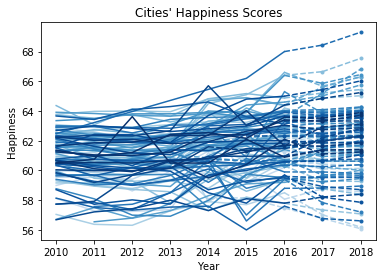

In [54]:
# the cities we've ended up with data for, which is 7 fewer than our original wishlist
final_cities = set(data.index.get_level_values('city'))

for i, city in enumerate(final_cities):
    years = np.array([int(year) for year in data['happiness'].loc[city].index])
    happinesses = np.array(data['happiness'].loc[city].values)
    
    new_years = np.array(range(years[-1]+1, 2018+1))
    new_happinesses = sk_LinearRegression()    \
                    .fit(years.reshape((-1, 1)), happinesses.reshape((-1, 1))) \
                    .predict(new_years.reshape((-1, 1)))

    color = plt.get_cmap('Blues')(i*.75/len(final_cities)+.25)
    plt.plot(years, happinesses, '-', c=color)
    plt.plot([years[-1], new_years[0]], [happinesses[-1], new_happinesses[0]], '--', c=color)
    plt.plot(new_years, new_happinesses, '.--', c=color)
plt.title("Cities' Happiness Scores")
plt.ylabel("Happiness")
plt.xlabel("Year")
plt.show()

No contest here—Honolulu is projected to be the happiest city for apparently all of time.

# $\textrm{Privacy/Ethics Considerations}$

# $\textrm{Conclusions and Discussion}$